In [1]:
import math
import numpy as np
import pandas as pd
# package to read and write geospatial raster data
import rasterio

# for reprojection
import rasterio.crs
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.mask import mask

from matplotlib import pyplot as plt

import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')
from rasterstats import zonal_stats


In [2]:
ds = rasterio.open('../data/Vic_Rainfall/Victoria rainfall grid.asc', 'r')

In [3]:

dest_crs = rasterio.crs.CRS.from_epsg(7855)

# output resolution (1km by 1km cell size for the new, transformed BoM raster - we are
# starting off with what is already a very low-resolution raster, so it does not make
# sense to use a finer resolution here)
out_res = (1000, 1000)

# calculating transform array and shape of reprojected raster
out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(ds.crs,
                                                                                 dest_crs,
                                                                                 ds.width,
                                                                                 ds.height, 
                                                                                 resolution = out_res,
                                                                                 *ds.bounds)

out_profile = ds.profile

# updating destination raster metadata
out_profile['height'] = out_height
out_profile['width'] = out_width
out_profile['crs'] = dest_crs
out_profile['transform'] = out_transform

# defining output path and filename
out_raster_file = '../data/Vic_Rainfall/vic_rainfall_grid_epsg7855.tif'

# while exporting the raster we need to change the mode to 'w' and provide raster 'profile' parameters
# we also specify that the TIFF file should be compressed using the DEFLATE algorithm
with rasterio.open(out_raster_file, 'w', **out_profile, compress='DEFLATE') as ds_out:
    rasterio.warp.reproject(source = rasterio.band(ds, 1),
                            destination = rasterio.band(ds_out, 1),
                            src_crs = ds.crs,
                            dst_crs = ds_out.crs,
                            dst_resolution = out_res,
                            # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
                            resampling = Resampling.bilinear)
ds.close()

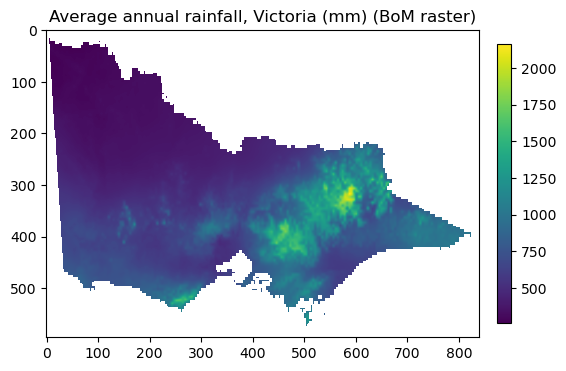

In [4]:
ds = rasterio.open('../data/Vic_Rainfall/vic_rainfall_grid_epsg7855.tif', 'r')
plt.figure(figsize = (6, 6))
band1 = ds.read(1)
band1[band1 == ds.nodata] = np.NaN
im = plt.imshow(band1, cmap = 'viridis')
plt.colorbar(im, fraction = 0.03, pad = 0.04)

plt.title('Average annual rainfall, Victoria (mm) (BoM raster)')

plt.show()

In [5]:
GCCSA = gpd.read_file('../data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelb = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']
geometries = GreaterMelb.geometry.values
out_image, out_transform = mask(ds, geometries, crop=True)

# Update the metadata
out_meta = ds.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the cropped raster to a new file
with rasterio.open('../output/Greater_Melbourne_rainfall_grid_epsg7855.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

In [6]:
boundary = gpd.read_file('../data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
boundary = boundary[boundary['GCC_NAME21'] == 'Greater Melbourne']
boundary['geometry'] = boundary['geometry'].to_crs('EPSG:7855')

stations = gpd.read_file('../data/curated/train_stations_in_sa2_postcovid/train_stations_in_sa2_postcovid.shp')
stations = stations[['Station_Na', 'SA2_NAME21']]

In [7]:
# Calculate zonal statistics
stats = zonal_stats(boundary, band1, stats='mean', affine=ds.transform)
# Add the mean values to the GeoDataFrame
boundary['mean_rainfall_value'] = [stat['mean'] for stat in stats]
boundary = boundary[['SA2_NAME21', 'geometry', 'mean_rainfall_value']]
boundary['mean_rainfall_value'].fillna(boundary['mean_rainfall_value'].mean(), inplace=True)

In [11]:
rainfall_data = pd.merge(boundary, stations, how='left', on='SA2_NAME21')
#rainfall_data['SA2_NAME21'] = rainfall_data['SA2_NAME21'].apply(lambda x: x + ' (SA2)')
rainfall_data.drop(['geometry'], axis=1, inplace=True)
rainfall_data.to_csv('../output/rainfall_Station_SA2.csv', index=False)

In [9]:
#rainfall_data['Station_Na'] = rainfall_data['Station_Na'].fillna(rainfall_data['SA2_NAME21'])
#rainfall_data = rainfall_data[['mean_rainfall_value', 'Station_Na']]
#rainfall_data.columns = ['mean_rainfall_value', 'Name']